# CIFAR10 with CNNs
Simple starter notebook to benchmark your own CNN with PyTorch on the CIFAR-10 dataset.

OBS.:

- The main code is basically done, so focus on training the models and searching for the best hyperparameters and architectures.
- You are not required to use this exact code or even the PyTorch library.
- It is recommended to use execution environments with GPU access (such as Google Colab), since larger models will take more time to train.
- Remember to document the history of your experiments and which results motivated the changes in subsequent experiments.

In [1]:
#@title Libs

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

from tqdm import tqdm

In [2]:
#@title Dataset Setup

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

100%|██████████| 170M/170M [00:02<00:00, 75.0MB/s]


### Class Visualization

Antes de iniciar o treinamento, foi realizada uma breve análise exploratória dos dados (EDA), com o objetivo de entender a estrutura e a distribuição das classes no conjunto CIFAR-10. Para isso, selecionamos aleatoriamente algumas imagens do conjunto de treinamento e as exibimos junto com seus rótulos.

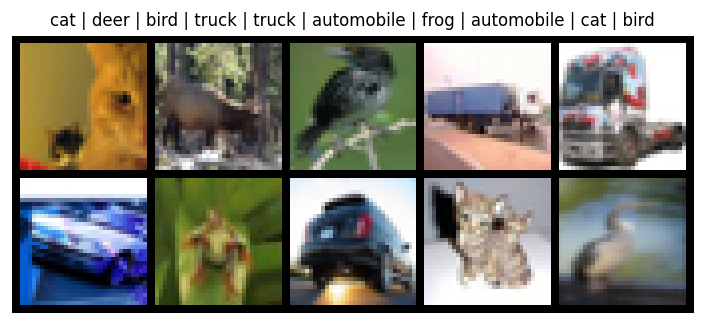

In [14]:
# CIFAR-10 classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# Função para mostrar imagens
def show_images(images, labels, class_names, nrow=5):
    # Desfaz a normalização
    images = images / 2 + 0.5
    npimg = torchvision.utils.make_grid(images, nrow=nrow).numpy()
    fig, ax = plt.subplots(figsize=(nrow * 2.5, 3), dpi=120)
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.axis('off')
    # Adiciona os rótulos
    title = ' | '.join(f'{class_names[labels[i]]}' for i in range(len(labels)))
    ax.set_title(title, fontsize=10)
    plt.show()

# Obtenho algumas imagens do DataLoader
dataiter = iter(torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True))
images, labels = next(dataiter)

# Mostra as imagens
show_images(images, labels, classes)

### Distribuição das classes no treino e teste

Além da visualização, foi analisada a distribuição quantitativa das classes nos conjuntos de treino e teste. O CIFAR-10 é um dataset equilibrado, o que significa que cada uma das 10 classes está representada com aproximadamente o mesmo número de exemplos em ambos os conjuntos.

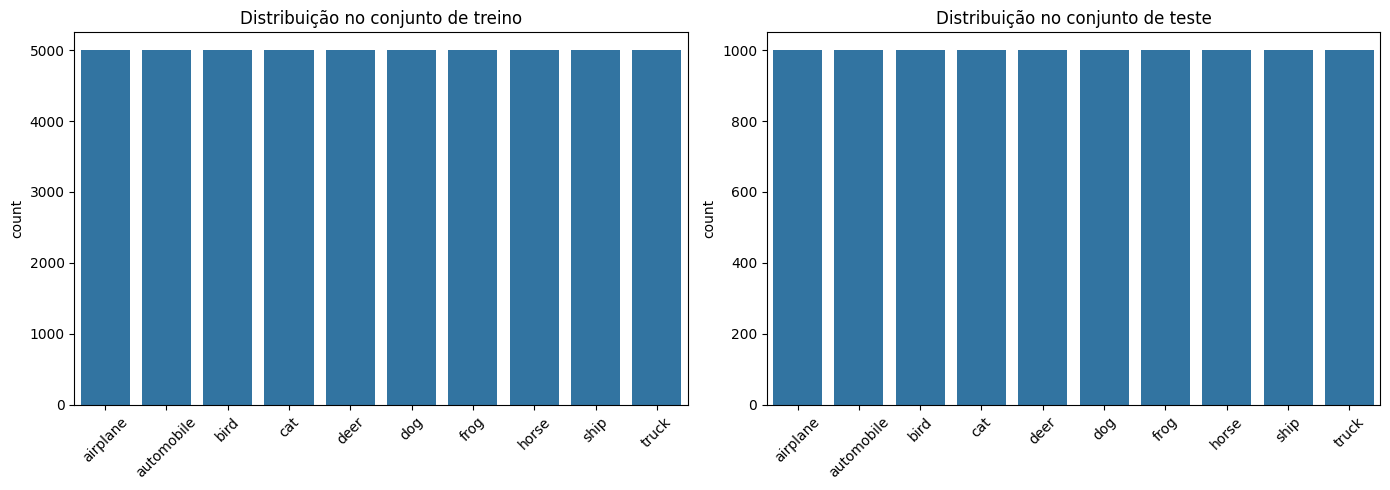

In [15]:
import seaborn as sns

# Obtenho todos os rótulos do dataset
train_labels = [label for _, label in train_dataset]
test_labels = [label for _, label in test_dataset]

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Contagem no treino
sns.countplot(x=train_labels, ax=axs[0])
axs[0].set_title("Distribuição no conjunto de treino")
axs[0].set_xticks(range(len(classes)))
axs[0].set_xticklabels(classes, rotation=45)

# Contagem no teste
sns.countplot(x=test_labels, ax=axs[1])
axs[1].set_title("Distribuição no conjunto de teste")
axs[1].set_xticks(range(len(classes)))
axs[1].set_xticklabels(classes, rotation=45)

plt.tight_layout()
plt.show()

Para garantir uma avaliação justa do desempenho do modelo durante o treinamento, dividimos o conjunto de treinamento original em dois subconjuntos: treino e validação. Essa divisão foi feita na proporção de 80% para treino e 20% para validação, utilizando a função random_split da biblioteca PyTorch.

A separação dos dados de validação permite monitorar a capacidade de generalização do modelo a cada época de treinamento, sem recorrer ao conjunto de teste. Além disso, essa estratégia viabiliza o uso de técnicas como early stopping, que interrompe o treinamento quando não há mais melhora na performance de validação, evitando o overfitting.

O uso da seed fixa torch.manual_seed(42) garante que a divisão aleatória dos dados seja reprodutível, ou seja, igual em todas as execuções.

In [21]:
from torch.utils.data import random_split, DataLoader

# Proporção treino/validação
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

# Divisão aleatória
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Loaders para treino e validação
batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

torch.manual_seed(42)

print(f"Tamanho do conjunto de treino: {len(train_subset)}")
print(f"Tamanho do conjunto de validação: {len(val_subset)}")

Tamanho do conjunto de treino: 40000
Tamanho do conjunto de validação: 10000


In [22]:
# Verifico se o intervalo de pixel está dentro do que apliquei em transforms.Normalize((0.5,...)
img, _ = train_dataset[0]
print("Valor mínimo:", img.min().item())
print("Valor máximo:", img.max().item())
# verifico se meu formato e dimensão equivalem ao que defini
print("Shape da imagem:", img.shape)  # deve ser [3, 32, 32]


Valor mínimo: -1.0
Valor máximo: 1.0
Shape da imagem: torch.Size([3, 32, 32])


# Arquitetura do Primeiro Modelo

A primeira rede convolucional (FirstCNN) segue uma estrutura simples e tradicional de CNNs.

Na primeira etapa, aplicamos uma convolução com 32 filtros de 3x3 com padding 1, preservando a dimensão da entrada. Em seguida, uma nova convolução com 32 filtros e sem padding, ambas seguidas por ReLU. Em seguida, realizamos uma operação de max pooling 2x2 e dropout de 25%.

Na segunda etapa, repetimos a lógica com convoluções de 64 filtros, novamente seguidas por ReLU, pooling e dropout.

Na etapa final, usamos um flatten para converter os mapas de ativação em vetor, seguido de uma camada densa com 512 neurônios e ativação ReLU, dropout de 50% e por fim, uma camada de saída com 10 neurônios correspondentes às classes do CIFAR-10.

In [23]:
class FirstCNNModel(nn.Module):
    def __init__(self):
        super(FirstCNNModel, self).__init__()
        self.features = nn.Sequential(
            # 1 camada
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            # 2 camada
            nn.Conv2d(32, 32, 3),
            nn.ReLU(),

            nn.MaxPool2d(2),

            nn.Dropout(0.25),

            # 3 camada
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            # 4 camada com 64 filtros
            nn.Conv2d(64, 64, 3),
            nn.ReLU(),

            nn.MaxPool2d(2),

            nn.Dropout(0.25)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 6 * 6, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FirstCNNModel().to(device)

O treinamento foi feito utilizando o otimizador Adam com taxa de aprendizado 0.001 e a função de perda CrossEntropyLoss. Implementamos early stopping com paciência de 7 épocas, o que significa que o treinamento é interrompido caso a perda de validação não melhore por 7 épocas consecutivas.

In [27]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100

In [32]:
# Função para treinar uma época

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss / total, correct / total

# Função de validação

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return running_loss / total, correct / total

# Classe de early stopping
class EarlyStopping:
    def __init__(self, patience=7, verbose=True):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.verbose = verbose
        self.best_model_state = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
            self.counter = 0
            if self.verbose:
                print(f"Validação melhorou. Novo menor loss: {val_loss:.4f}")
        else:
            self.counter += 1
            if self.verbose:
                print(f"Sem melhora ({self.counter}/{self.patience})")
            if self.counter >= self.patience:
                self.early_stop = True

In [34]:
from tqdm import trange

train_losses, val_losses = [], []
train_accs, val_accs = [], []
early_stopping = EarlyStopping(patience=7)

for epoch in trange(num_epochs, desc="Treinando", unit="época"):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Época {epoch+1:02d}: Train Loss={train_loss:.4f}, Acc={train_acc*100:.2f}% | Val Loss={val_loss:.4f}, Acc={val_acc*100:.2f}%")

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Treinamento interrompido por Early Stopping.")
        break

# Restaura o melhor modelo salvo
model.load_state_dict(early_stopping.best_model_state)

Treinando:   1%|          | 1/100 [00:20<33:31, 20.32s/época]

Época 01: Train Loss=0.8153, Acc=71.33% | Val Loss=0.7490, Acc=73.75%
Validação melhorou. Novo menor loss: 0.7490


Treinando:   2%|▏         | 2/100 [00:40<32:40, 20.00s/época]

Época 02: Train Loss=0.7615, Acc=73.23% | Val Loss=0.7330, Acc=74.83%
Validação melhorou. Novo menor loss: 0.7330


Treinando:   3%|▎         | 3/100 [00:59<31:39, 19.58s/época]

Época 03: Train Loss=0.7253, Acc=74.72% | Val Loss=0.7028, Acc=75.34%
Validação melhorou. Novo menor loss: 0.7028


Treinando:   4%|▍         | 4/100 [01:19<31:28, 19.68s/época]

Época 04: Train Loss=0.6885, Acc=75.81% | Val Loss=0.6741, Acc=76.08%
Validação melhorou. Novo menor loss: 0.6741


Treinando:   5%|▌         | 5/100 [01:38<31:19, 19.79s/época]

Época 05: Train Loss=0.6675, Acc=76.68% | Val Loss=0.7085, Acc=75.41%
Sem melhora (1/7)


Treinando:   6%|▌         | 6/100 [01:58<30:46, 19.65s/época]

Época 06: Train Loss=0.6415, Acc=77.61% | Val Loss=0.6614, Acc=77.35%
Validação melhorou. Novo menor loss: 0.6614


Treinando:   7%|▋         | 7/100 [02:18<30:32, 19.70s/época]

Época 07: Train Loss=0.6237, Acc=77.96% | Val Loss=0.6844, Acc=76.85%
Sem melhora (1/7)


Treinando:   8%|▊         | 8/100 [02:37<29:58, 19.54s/época]

Época 08: Train Loss=0.5912, Acc=79.14% | Val Loss=0.6770, Acc=77.17%
Sem melhora (2/7)


Treinando:   9%|▉         | 9/100 [02:57<29:48, 19.66s/época]

Época 09: Train Loss=0.5771, Acc=79.76% | Val Loss=0.6765, Acc=76.96%
Sem melhora (3/7)


Treinando:  10%|█         | 10/100 [03:17<29:44, 19.83s/época]

Época 10: Train Loss=0.5627, Acc=80.05% | Val Loss=0.7025, Acc=76.31%
Sem melhora (4/7)


Treinando:  11%|█         | 11/100 [03:36<29:04, 19.60s/época]

Época 11: Train Loss=0.5519, Acc=80.45% | Val Loss=0.6714, Acc=77.55%
Sem melhora (5/7)


Treinando:  12%|█▏        | 12/100 [03:56<28:50, 19.66s/época]

Época 12: Train Loss=0.5336, Acc=81.26% | Val Loss=0.7127, Acc=76.60%
Sem melhora (6/7)


Treinando:  12%|█▏        | 12/100 [04:16<31:17, 21.34s/época]

Época 13: Train Loss=0.5203, Acc=81.56% | Val Loss=0.7160, Acc=77.00%
Sem melhora (7/7)
Treinamento interrompido por Early Stopping.


<All keys matched successfully>

Ao longo do treinamento, observamos uma progressiva melhoria nas métricas de desempenho até a época 4, quando o modelo alcançou sua melhor validação até então (Val Loss = 0.6741; Val Acc = 76.08%). Após essa época, embora a acurácia de treino tenha continuado a subir (atingindo 81.56% na época 13), a validação começou a oscilar e apresentou tendência de estabilização, indicando um possível início de sobreajuste.

O early stopping foi ativado ao final da época 13, uma vez que o modelo não apresentou novas melhoras no loss de validação durante sete épocas consecutivas. Esse mecanismo foi eficaz em interromper o treinamento no ponto ótimo, prevenindo que o modelo aprendesse ruídos do conjunto de treino.

Esse comportamento mostra que a arquitetura FirstCNN possui boa capacidade de aprendizado, conseguindo atingir aproximadamente 76–77% de acurácia em validação em apenas 13 épocas. Ainda assim, apresenta limitações em sua generalização frente a arquiteturas mais robustas.

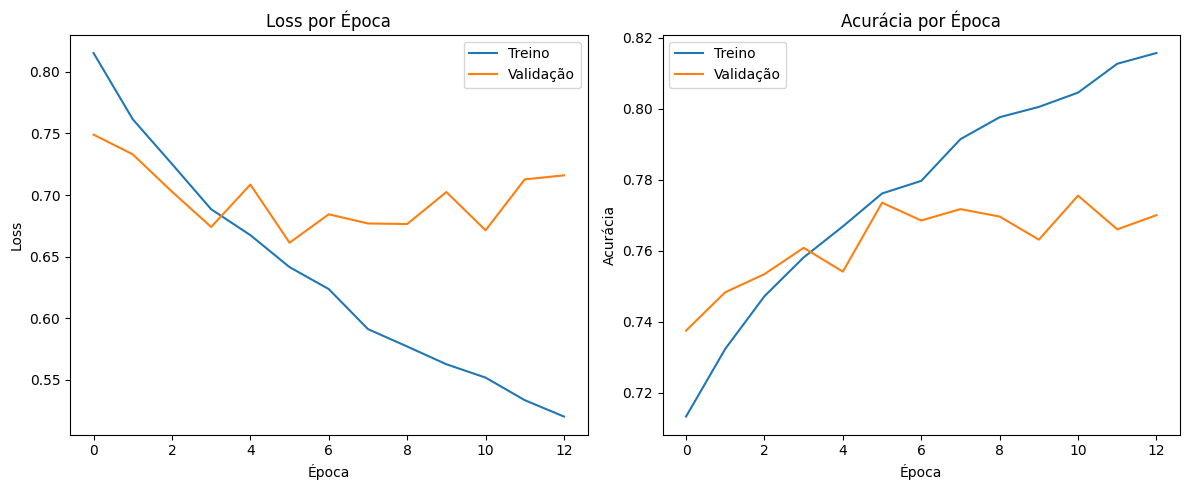

In [35]:
# Plota os gráficos de loss e acurácia
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Treino')
plt.plot(val_losses, label='Validação')
plt.title('Loss por Época')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Treino')
plt.plot(val_accs, label='Validação')
plt.title('Acurácia por Época')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.tight_layout()
plt.show()

O gráfico de loss mostra uma queda contínua na perda de treinamento ao longo das épocas, enquanto a perda de validação apresenta oscilações e estabiliza por volta da época 4 a 6. Isso sugere que, embora o modelo continue aprendendo no conjunto de treino, sua capacidade de generalização para dados não vistos estagna e começa a decair.

Já o gráfico de acurácia mostra um crescimento consistente no conjunto de treino, chegando a ultrapassar 81% ao final do processo. No entanto, a acurácia de validação alcança seu pico por volta da época 6 e oscila levemente a partir daí, indicando início de overfitting.

Esses comportamentos justificam o acionamento do early stopping na época 13, evitando que o modelo fizesse overfitting dos dados de treino. A combinação de melhora inicial e posterior estabilização reforça que o modelo possui uma capacidade limitada de generalização, coerente com sua simplicidade.

Acurácia:              0.7715
Acurácia Balanceada:   0.7715
Precisão (macro):      0.7807
Recall (macro):        0.7715
F1-Score (macro):      0.7733


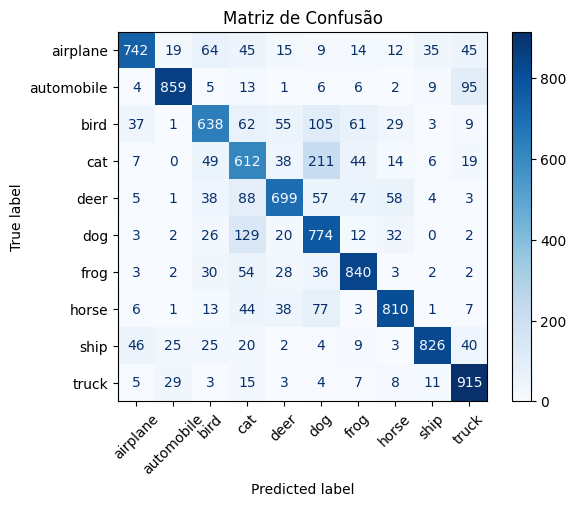

{'accuracy': 0.7715,
 'balanced_accuracy': np.float64(0.7715),
 'precision': 0.7807234911827351,
 'recall': 0.7715,
 'f1': 0.7733062941274559}

In [39]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

def evaluate_full_metrics(model, loader, device, class_names=None, show_confusion=True):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds, all_labels = np.array(all_preds), np.array(all_labels)
    acc = accuracy_score(all_labels, all_preds)
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"Acurácia:              {acc:.4f}")
    print(f"Acurácia Balanceada:   {balanced_acc:.4f}")
    print(f"Precisão (macro):      {precision:.4f}")
    print(f"Recall (macro):        {recall:.4f}")
    print(f"F1-Score (macro):      {f1:.4f}")

    if show_confusion:
        cm = confusion_matrix(all_labels, all_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(xticks_rotation=45, cmap='Blues')
        plt.title("Matriz de Confusão")
        plt.show()

    return {
        "accuracy": acc,
        "balanced_accuracy": balanced_acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

#Loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Executa avaliação final no conjunto de teste
evaluate_full_metrics(model, test_loader, device, class_names=classes, show_confusion=True)


# Desempenho do Primeiro Modelo

O desempenho do modelo FirstCNN no conjunto de teste resultou em uma acurácia de 77,15%, com acurácia balanceada de 77,15%, precisão macro de 78,07%, recall macro de 77,15% e F1-score macro de 77,33%. Esses resultados indicam uma boa capacidade de generalização, especialmente para um modelo de arquitetura relativamente simples.

A matriz de confusão revela que o modelo é especialmente competente em identificar classes como "truck" (915 acertos), "automobile" (859 acertos) e "ship" (826 acertos), enquanto apresenta maior dificuldade em distinguir entre algumas categorias de animais. Por exemplo, a classe "cat" foi frequentemente confundida com "dog" (211 erros) e "deer" (84 erros), o que é compreensível considerando a semelhança visual entre essas classes em imagens pequenas como as do CIFAR-10.

Da mesma forma, observa-se confusão entre "horse" e "deer", bem como entre "bird" e "cat", indicando que as feições visuais semelhantes entre alguns animais limitam a capacidade do modelo de fazer distinções mais precisas. Isso reforça a importância do uso de modelos mais complexos ou técnicas como data augmentation para melhorar a discriminação entre essas categorias.

# Arquitetura do Segundo Modelo
A segunda arquitetura é mais profunda e robusta, sendo composta por três blocos convolucionais:

O primeiro bloco aplica duas convoluções com 64 filtros, padding 1, seguidas por batch normalization e ReLU. Após isso, max pooling 2x2 e dropout de 25%.

O segundo bloco segue a mesma estrutura, mas com 128 filtros.

O terceiro bloco aplica uma única convolução com 256 filtros, seguida por batch normalization, ReLU, max pooling e dropout.

Na etapa final, o vetor resultante é achatado e passa por uma camada densa com 512 neurônios e ReLU, seguida por dropout de 50% e uma camada de saída com 10 neurônios.

In [40]:
class DeeperCNN(nn.Module):
    def __init__(self):
        super(DeeperCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [41]:
model2 = DeeperCNN().to(device)
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
early_stopping2 = EarlyStopping(patience=7)

train_losses2, val_losses2 = [], []
train_accs2, val_accs2 = [], []

for epoch in trange(100, desc="Treinando Modelo 2", unit="época"):
    train_loss, train_acc = train_one_epoch(model2, train_loader, optimizer2, criterion2, device)
    val_loss, val_acc = evaluate(model2, val_loader, criterion2, device)

    train_losses2.append(train_loss)
    val_losses2.append(val_loss)
    train_accs2.append(train_acc)
    val_accs2.append(val_acc)

    print(f"Época {epoch+1:02d}: Train Loss={train_loss:.4f}, Acc={train_acc*100:.2f}% | Val Loss={val_loss:.4f}, Acc={val_acc*100:.2f}%")

    early_stopping2(val_loss, model2)
    if early_stopping2.early_stop:
        print("Early stopping acionado para o Modelo 2.")
        break

# Restaura o melhor estado do modelo
model2.load_state_dict(early_stopping2.best_model_state)

Treinando Modelo 2:   1%|          | 1/100 [00:28<47:14, 28.63s/época]

Época 01: Train Loss=1.5314, Acc=43.77% | Val Loss=1.1541, Acc=57.85%
Validação melhorou. Novo menor loss: 1.1541


Treinando Modelo 2:   2%|▏         | 2/100 [00:57<46:51, 28.69s/época]

Época 02: Train Loss=1.1467, Acc=59.27% | Val Loss=0.8645, Acc=68.86%
Validação melhorou. Novo menor loss: 0.8645


Treinando Modelo 2:   3%|▎         | 3/100 [01:25<45:44, 28.29s/época]

Época 03: Train Loss=0.9691, Acc=66.07% | Val Loss=0.6786, Acc=76.27%
Validação melhorou. Novo menor loss: 0.6786


Treinando Modelo 2:   4%|▍         | 4/100 [01:53<45:08, 28.21s/época]

Época 04: Train Loss=0.8609, Acc=70.34% | Val Loss=0.7111, Acc=74.86%
Sem melhora (1/7)


Treinando Modelo 2:   5%|▌         | 5/100 [02:21<44:44, 28.25s/época]

Época 05: Train Loss=0.7839, Acc=73.30% | Val Loss=0.7237, Acc=74.93%
Sem melhora (2/7)


Treinando Modelo 2:   6%|▌         | 6/100 [02:49<44:07, 28.16s/época]

Época 06: Train Loss=0.7119, Acc=75.79% | Val Loss=0.4805, Acc=83.08%
Validação melhorou. Novo menor loss: 0.4805


Treinando Modelo 2:   7%|▋         | 7/100 [03:17<43:23, 27.99s/época]

Época 07: Train Loss=0.6516, Acc=77.87% | Val Loss=0.4113, Acc=86.01%
Validação melhorou. Novo menor loss: 0.4113


Treinando Modelo 2:   8%|▊         | 8/100 [03:45<43:11, 28.17s/época]

Época 08: Train Loss=0.6006, Acc=79.78% | Val Loss=0.3682, Acc=87.41%
Validação melhorou. Novo menor loss: 0.3682


Treinando Modelo 2:   9%|▉         | 9/100 [04:13<42:27, 27.99s/época]

Época 09: Train Loss=0.5651, Acc=80.87% | Val Loss=0.3473, Acc=87.86%
Validação melhorou. Novo menor loss: 0.3473


Treinando Modelo 2:  10%|█         | 10/100 [04:41<42:03, 28.04s/época]

Época 10: Train Loss=0.5218, Acc=82.50% | Val Loss=0.2937, Acc=89.86%
Validação melhorou. Novo menor loss: 0.2937


Treinando Modelo 2:  11%|█         | 11/100 [05:09<41:41, 28.11s/época]

Época 11: Train Loss=0.4899, Acc=83.47% | Val Loss=0.2606, Acc=91.27%
Validação melhorou. Novo menor loss: 0.2606


Treinando Modelo 2:  12%|█▏        | 12/100 [05:37<41:06, 28.02s/época]

Época 12: Train Loss=0.4579, Acc=84.63% | Val Loss=0.2549, Acc=91.41%
Validação melhorou. Novo menor loss: 0.2549


Treinando Modelo 2:  13%|█▎        | 13/100 [06:05<40:34, 27.98s/época]

Época 13: Train Loss=0.4334, Acc=85.40% | Val Loss=0.2074, Acc=93.72%
Validação melhorou. Novo menor loss: 0.2074


Treinando Modelo 2:  14%|█▍        | 14/100 [06:33<40:00, 27.91s/época]

Época 14: Train Loss=0.4080, Acc=86.14% | Val Loss=0.1952, Acc=93.45%
Validação melhorou. Novo menor loss: 0.1952


Treinando Modelo 2:  15%|█▌        | 15/100 [07:01<39:38, 27.98s/época]

Época 15: Train Loss=0.3885, Acc=86.79% | Val Loss=0.1884, Acc=93.99%
Validação melhorou. Novo menor loss: 0.1884


Treinando Modelo 2:  16%|█▌        | 16/100 [07:29<39:02, 27.89s/época]

Época 16: Train Loss=0.3702, Acc=87.51% | Val Loss=0.1636, Acc=94.95%
Validação melhorou. Novo menor loss: 0.1636


Treinando Modelo 2:  17%|█▋        | 17/100 [07:56<38:20, 27.72s/época]

Época 17: Train Loss=0.3564, Acc=88.00% | Val Loss=0.1464, Acc=95.33%
Validação melhorou. Novo menor loss: 0.1464


Treinando Modelo 2:  18%|█▊        | 18/100 [08:24<37:58, 27.78s/época]

Época 18: Train Loss=0.3338, Acc=88.64% | Val Loss=0.1445, Acc=95.29%
Validação melhorou. Novo menor loss: 0.1445


Treinando Modelo 2:  19%|█▉        | 19/100 [08:52<37:35, 27.84s/época]

Época 19: Train Loss=0.3271, Acc=88.95% | Val Loss=0.1263, Acc=96.30%
Validação melhorou. Novo menor loss: 0.1263


Treinando Modelo 2:  20%|██        | 20/100 [09:19<36:54, 27.68s/época]

Época 20: Train Loss=0.3080, Acc=89.53% | Val Loss=0.1242, Acc=96.04%
Validação melhorou. Novo menor loss: 0.1242


Treinando Modelo 2:  21%|██        | 21/100 [09:46<36:18, 27.58s/época]

Época 21: Train Loss=0.2993, Acc=89.97% | Val Loss=0.1205, Acc=96.41%
Validação melhorou. Novo menor loss: 0.1205


Treinando Modelo 2:  22%|██▏       | 22/100 [10:15<36:05, 27.77s/época]

Época 22: Train Loss=0.2868, Acc=90.29% | Val Loss=0.0985, Acc=97.29%
Validação melhorou. Novo menor loss: 0.0985


Treinando Modelo 2:  23%|██▎       | 23/100 [10:42<35:39, 27.79s/época]

Época 23: Train Loss=0.2798, Acc=90.58% | Val Loss=0.0937, Acc=97.18%
Validação melhorou. Novo menor loss: 0.0937


Treinando Modelo 2:  24%|██▍       | 24/100 [11:10<35:16, 27.85s/época]

Época 24: Train Loss=0.2727, Acc=90.88% | Val Loss=0.0897, Acc=97.32%
Validação melhorou. Novo menor loss: 0.0897


Treinando Modelo 2:  25%|██▌       | 25/100 [11:39<34:58, 27.98s/época]

Época 25: Train Loss=0.2596, Acc=91.22% | Val Loss=0.0814, Acc=97.87%
Validação melhorou. Novo menor loss: 0.0814


Treinando Modelo 2:  26%|██▌       | 26/100 [12:07<34:28, 27.95s/época]

Época 26: Train Loss=0.2555, Acc=91.36% | Val Loss=0.0712, Acc=97.98%
Validação melhorou. Novo menor loss: 0.0712


Treinando Modelo 2:  27%|██▋       | 27/100 [12:35<33:59, 27.94s/época]

Época 27: Train Loss=0.2434, Acc=91.87% | Val Loss=0.0641, Acc=98.25%
Validação melhorou. Novo menor loss: 0.0641


Treinando Modelo 2:  28%|██▊       | 28/100 [13:02<33:24, 27.84s/época]

Época 28: Train Loss=0.2388, Acc=91.99% | Val Loss=0.0633, Acc=98.34%
Validação melhorou. Novo menor loss: 0.0633


Treinando Modelo 2:  29%|██▉       | 29/100 [13:31<33:09, 28.02s/época]

Época 29: Train Loss=0.2334, Acc=92.16% | Val Loss=0.0682, Acc=98.05%
Sem melhora (1/7)


Treinando Modelo 2:  30%|███       | 30/100 [13:59<32:39, 27.99s/época]

Época 30: Train Loss=0.2262, Acc=92.28% | Val Loss=0.0606, Acc=98.39%
Validação melhorou. Novo menor loss: 0.0606


Treinando Modelo 2:  31%|███       | 31/100 [14:26<32:06, 27.92s/época]

Época 31: Train Loss=0.2231, Acc=92.53% | Val Loss=0.0579, Acc=98.70%
Validação melhorou. Novo menor loss: 0.0579


Treinando Modelo 2:  32%|███▏      | 32/100 [14:55<31:46, 28.03s/época]

Época 32: Train Loss=0.2180, Acc=92.53% | Val Loss=0.0509, Acc=98.94%
Validação melhorou. Novo menor loss: 0.0509


Treinando Modelo 2:  33%|███▎      | 33/100 [15:23<31:16, 28.00s/época]

Época 33: Train Loss=0.2176, Acc=92.64% | Val Loss=0.0448, Acc=99.03%
Validação melhorou. Novo menor loss: 0.0448


Treinando Modelo 2:  34%|███▍      | 34/100 [15:51<30:51, 28.05s/época]

Época 34: Train Loss=0.1997, Acc=93.18% | Val Loss=0.0423, Acc=98.97%
Validação melhorou. Novo menor loss: 0.0423


Treinando Modelo 2:  35%|███▌      | 35/100 [16:19<30:30, 28.16s/época]

Época 35: Train Loss=0.1994, Acc=93.10% | Val Loss=0.0340, Acc=99.29%
Validação melhorou. Novo menor loss: 0.0340


Treinando Modelo 2:  36%|███▌      | 36/100 [16:47<29:55, 28.06s/época]

Época 36: Train Loss=0.1954, Acc=93.31% | Val Loss=0.0414, Acc=99.07%
Sem melhora (1/7)


Treinando Modelo 2:  37%|███▋      | 37/100 [17:14<29:17, 27.90s/época]

Época 37: Train Loss=0.1884, Acc=93.65% | Val Loss=0.0360, Acc=99.19%
Sem melhora (2/7)


Treinando Modelo 2:  38%|███▊      | 38/100 [17:43<28:55, 27.99s/época]

Época 38: Train Loss=0.1866, Acc=93.57% | Val Loss=0.0288, Acc=99.37%
Validação melhorou. Novo menor loss: 0.0288


Treinando Modelo 2:  39%|███▉      | 39/100 [18:11<28:36, 28.14s/época]

Época 39: Train Loss=0.1846, Acc=93.80% | Val Loss=0.0286, Acc=99.37%
Validação melhorou. Novo menor loss: 0.0286


Treinando Modelo 2:  40%|████      | 40/100 [18:39<28:02, 28.04s/época]

Época 40: Train Loss=0.1799, Acc=93.93% | Val Loss=0.0336, Acc=99.22%
Sem melhora (1/7)


Treinando Modelo 2:  41%|████      | 41/100 [19:07<27:29, 27.95s/época]

Época 41: Train Loss=0.1790, Acc=93.88% | Val Loss=0.0253, Acc=99.53%
Validação melhorou. Novo menor loss: 0.0253


Treinando Modelo 2:  42%|████▏     | 42/100 [19:35<27:13, 28.16s/época]

Época 42: Train Loss=0.1745, Acc=94.13% | Val Loss=0.0273, Acc=99.44%
Sem melhora (1/7)


Treinando Modelo 2:  43%|████▎     | 43/100 [20:03<26:39, 28.07s/época]

Época 43: Train Loss=0.1661, Acc=94.33% | Val Loss=0.0220, Acc=99.61%
Validação melhorou. Novo menor loss: 0.0220


Treinando Modelo 2:  44%|████▍     | 44/100 [20:31<26:06, 27.97s/época]

Época 44: Train Loss=0.1648, Acc=94.36% | Val Loss=0.0210, Acc=99.58%
Validação melhorou. Novo menor loss: 0.0210


Treinando Modelo 2:  45%|████▌     | 45/100 [21:00<25:50, 28.19s/época]

Época 45: Train Loss=0.1676, Acc=94.32% | Val Loss=0.0277, Acc=99.30%
Sem melhora (1/7)


Treinando Modelo 2:  46%|████▌     | 46/100 [21:27<25:10, 27.97s/época]

Época 46: Train Loss=0.1639, Acc=94.49% | Val Loss=0.0246, Acc=99.55%
Sem melhora (2/7)


Treinando Modelo 2:  47%|████▋     | 47/100 [21:55<24:36, 27.86s/época]

Época 47: Train Loss=0.1568, Acc=94.73% | Val Loss=0.0237, Acc=99.60%
Sem melhora (3/7)


Treinando Modelo 2:  48%|████▊     | 48/100 [22:23<24:07, 27.84s/época]

Época 48: Train Loss=0.1569, Acc=94.75% | Val Loss=0.0172, Acc=99.76%
Validação melhorou. Novo menor loss: 0.0172


Treinando Modelo 2:  49%|████▉     | 49/100 [22:51<23:45, 27.94s/época]

Época 49: Train Loss=0.1549, Acc=94.94% | Val Loss=0.0203, Acc=99.65%
Sem melhora (1/7)


Treinando Modelo 2:  50%|█████     | 50/100 [23:18<23:15, 27.90s/época]

Época 50: Train Loss=0.1517, Acc=94.79% | Val Loss=0.0133, Acc=99.82%
Validação melhorou. Novo menor loss: 0.0133


Treinando Modelo 2:  51%|█████     | 51/100 [23:46<22:46, 27.89s/época]

Época 51: Train Loss=0.1508, Acc=95.00% | Val Loss=0.0203, Acc=99.65%
Sem melhora (1/7)


Treinando Modelo 2:  52%|█████▏    | 52/100 [24:15<22:27, 28.07s/época]

Época 52: Train Loss=0.1500, Acc=95.03% | Val Loss=0.0156, Acc=99.83%
Sem melhora (2/7)


Treinando Modelo 2:  53%|█████▎    | 53/100 [24:43<21:54, 27.97s/época]

Época 53: Train Loss=0.1396, Acc=95.30% | Val Loss=0.0152, Acc=99.72%
Sem melhora (3/7)


Treinando Modelo 2:  54%|█████▍    | 54/100 [25:10<21:24, 27.93s/época]

Época 54: Train Loss=0.1442, Acc=95.11% | Val Loss=0.0153, Acc=99.73%
Sem melhora (4/7)


Treinando Modelo 2:  55%|█████▌    | 55/100 [25:39<21:03, 28.09s/época]

Época 55: Train Loss=0.1380, Acc=95.41% | Val Loss=0.0123, Acc=99.85%
Validação melhorou. Novo menor loss: 0.0123


Treinando Modelo 2:  56%|█████▌    | 56/100 [26:07<20:33, 28.03s/época]

Época 56: Train Loss=0.1369, Acc=95.41% | Val Loss=0.0118, Acc=99.86%
Validação melhorou. Novo menor loss: 0.0118


Treinando Modelo 2:  57%|█████▋    | 57/100 [26:35<20:04, 28.01s/época]

Época 57: Train Loss=0.1452, Acc=95.21% | Val Loss=0.0150, Acc=99.72%
Sem melhora (1/7)


Treinando Modelo 2:  58%|█████▊    | 58/100 [27:03<19:43, 28.19s/época]

Época 58: Train Loss=0.1399, Acc=95.36% | Val Loss=0.0106, Acc=99.93%
Validação melhorou. Novo menor loss: 0.0106


Treinando Modelo 2:  59%|█████▉    | 59/100 [27:32<19:17, 28.22s/época]

Época 59: Train Loss=0.1330, Acc=95.61% | Val Loss=0.0098, Acc=99.82%
Validação melhorou. Novo menor loss: 0.0098


Treinando Modelo 2:  60%|██████    | 60/100 [27:59<18:44, 28.10s/época]

Época 60: Train Loss=0.1336, Acc=95.58% | Val Loss=0.0126, Acc=99.84%
Sem melhora (1/7)


Treinando Modelo 2:  61%|██████    | 61/100 [28:28<18:18, 28.17s/época]

Época 61: Train Loss=0.1289, Acc=95.73% | Val Loss=0.0099, Acc=99.94%
Sem melhora (2/7)


Treinando Modelo 2:  62%|██████▏   | 62/100 [28:56<17:50, 28.16s/época]

Época 62: Train Loss=0.1339, Acc=95.59% | Val Loss=0.0131, Acc=99.77%
Sem melhora (3/7)


Treinando Modelo 2:  63%|██████▎   | 63/100 [29:24<17:18, 28.07s/época]

Época 63: Train Loss=0.1284, Acc=95.72% | Val Loss=0.0094, Acc=99.90%
Validação melhorou. Novo menor loss: 0.0094


Treinando Modelo 2:  64%|██████▍   | 64/100 [29:51<16:46, 27.97s/época]

Época 64: Train Loss=0.1238, Acc=95.87% | Val Loss=0.0140, Acc=99.73%
Sem melhora (1/7)


Treinando Modelo 2:  65%|██████▌   | 65/100 [30:20<16:21, 28.05s/época]

Época 65: Train Loss=0.1290, Acc=95.78% | Val Loss=0.0104, Acc=99.90%
Sem melhora (2/7)


Treinando Modelo 2:  66%|██████▌   | 66/100 [30:48<15:52, 28.01s/época]

Época 66: Train Loss=0.1236, Acc=95.98% | Val Loss=0.0083, Acc=99.85%
Validação melhorou. Novo menor loss: 0.0083


Treinando Modelo 2:  67%|██████▋   | 67/100 [31:15<15:18, 27.83s/época]

Época 67: Train Loss=0.1241, Acc=95.81% | Val Loss=0.0083, Acc=99.89%
Validação melhorou. Novo menor loss: 0.0083


Treinando Modelo 2:  68%|██████▊   | 68/100 [31:43<14:53, 27.91s/época]

Época 68: Train Loss=0.1250, Acc=96.02% | Val Loss=0.0103, Acc=99.87%
Sem melhora (1/7)


Treinando Modelo 2:  69%|██████▉   | 69/100 [32:11<14:23, 27.86s/época]

Época 69: Train Loss=0.1241, Acc=95.94% | Val Loss=0.0089, Acc=99.91%
Sem melhora (2/7)


Treinando Modelo 2:  70%|███████   | 70/100 [32:39<13:53, 27.79s/época]

Época 70: Train Loss=0.1176, Acc=96.12% | Val Loss=0.0085, Acc=99.91%
Sem melhora (3/7)


Treinando Modelo 2:  71%|███████   | 71/100 [33:06<13:24, 27.75s/época]

Época 71: Train Loss=0.1171, Acc=96.19% | Val Loss=0.0075, Acc=99.91%
Validação melhorou. Novo menor loss: 0.0075


Treinando Modelo 2:  72%|███████▏  | 72/100 [33:35<13:02, 27.96s/época]

Época 72: Train Loss=0.1206, Acc=96.01% | Val Loss=0.0067, Acc=99.95%
Validação melhorou. Novo menor loss: 0.0067


Treinando Modelo 2:  73%|███████▎  | 73/100 [34:03<12:34, 27.94s/época]

Época 73: Train Loss=0.1174, Acc=96.25% | Val Loss=0.0071, Acc=99.92%
Sem melhora (1/7)


Treinando Modelo 2:  74%|███████▍  | 74/100 [34:30<12:02, 27.79s/época]

Época 74: Train Loss=0.1163, Acc=96.17% | Val Loss=0.0088, Acc=99.93%
Sem melhora (2/7)


Treinando Modelo 2:  75%|███████▌  | 75/100 [34:58<11:36, 27.84s/época]

Época 75: Train Loss=0.1140, Acc=96.22% | Val Loss=0.0061, Acc=99.94%
Validação melhorou. Novo menor loss: 0.0061


Treinando Modelo 2:  76%|███████▌  | 76/100 [35:26<11:06, 27.79s/época]

Época 76: Train Loss=0.1140, Acc=96.23% | Val Loss=0.0072, Acc=99.96%
Sem melhora (1/7)


Treinando Modelo 2:  77%|███████▋  | 77/100 [35:53<10:36, 27.67s/época]

Época 77: Train Loss=0.1153, Acc=96.16% | Val Loss=0.0053, Acc=99.96%
Validação melhorou. Novo menor loss: 0.0053


Treinando Modelo 2:  78%|███████▊  | 78/100 [36:21<10:10, 27.74s/época]

Época 78: Train Loss=0.1132, Acc=96.24% | Val Loss=0.0063, Acc=99.93%
Sem melhora (1/7)


Treinando Modelo 2:  79%|███████▉  | 79/100 [36:50<09:48, 28.00s/época]

Época 79: Train Loss=0.1094, Acc=96.29% | Val Loss=0.0058, Acc=99.95%
Sem melhora (2/7)


Treinando Modelo 2:  80%|████████  | 80/100 [37:17<09:16, 27.84s/época]

Época 80: Train Loss=0.1122, Acc=96.31% | Val Loss=0.0050, Acc=99.91%
Validação melhorou. Novo menor loss: 0.0050


Treinando Modelo 2:  81%|████████  | 81/100 [37:45<08:49, 27.86s/época]

Época 81: Train Loss=0.1094, Acc=96.50% | Val Loss=0.0050, Acc=99.96%
Sem melhora (1/7)


Treinando Modelo 2:  82%|████████▏ | 82/100 [38:13<08:25, 28.06s/época]

Época 82: Train Loss=0.1091, Acc=96.38% | Val Loss=0.0047, Acc=99.97%
Validação melhorou. Novo menor loss: 0.0047


Treinando Modelo 2:  83%|████████▎ | 83/100 [38:41<07:54, 27.93s/época]

Época 83: Train Loss=0.1115, Acc=96.35% | Val Loss=0.0061, Acc=99.97%
Sem melhora (1/7)


Treinando Modelo 2:  84%|████████▍ | 84/100 [39:09<07:26, 27.89s/época]

Época 84: Train Loss=0.1113, Acc=96.41% | Val Loss=0.0046, Acc=99.98%
Validação melhorou. Novo menor loss: 0.0046


Treinando Modelo 2:  85%|████████▌ | 85/100 [39:37<07:00, 28.02s/época]

Época 85: Train Loss=0.1014, Acc=96.74% | Val Loss=0.0052, Acc=99.96%
Sem melhora (1/7)


Treinando Modelo 2:  86%|████████▌ | 86/100 [40:05<06:30, 27.91s/época]

Época 86: Train Loss=0.1051, Acc=96.58% | Val Loss=0.0049, Acc=99.98%
Sem melhora (2/7)


Treinando Modelo 2:  87%|████████▋ | 87/100 [40:33<06:02, 27.89s/época]

Época 87: Train Loss=0.1072, Acc=96.49% | Val Loss=0.0051, Acc=99.89%
Sem melhora (3/7)


Treinando Modelo 2:  88%|████████▊ | 88/100 [41:00<05:34, 27.86s/época]

Época 88: Train Loss=0.1052, Acc=96.57% | Val Loss=0.0054, Acc=99.95%
Sem melhora (4/7)


Treinando Modelo 2:  89%|████████▉ | 89/100 [41:29<05:09, 28.16s/época]

Época 89: Train Loss=0.1016, Acc=96.73% | Val Loss=0.0035, Acc=100.00%
Validação melhorou. Novo menor loss: 0.0035


Treinando Modelo 2:  90%|█████████ | 90/100 [41:57<04:41, 28.10s/época]

Época 90: Train Loss=0.1017, Acc=96.69% | Val Loss=0.0036, Acc=99.98%
Sem melhora (1/7)


Treinando Modelo 2:  91%|█████████ | 91/100 [42:26<04:15, 28.43s/época]

Época 91: Train Loss=0.1042, Acc=96.61% | Val Loss=0.0043, Acc=99.97%
Sem melhora (2/7)


Treinando Modelo 2:  92%|█████████▏| 92/100 [42:55<03:47, 28.48s/época]

Época 92: Train Loss=0.1036, Acc=96.69% | Val Loss=0.0051, Acc=99.98%
Sem melhora (3/7)


Treinando Modelo 2:  93%|█████████▎| 93/100 [43:23<03:18, 28.32s/época]

Época 93: Train Loss=0.0980, Acc=96.75% | Val Loss=0.0055, Acc=99.90%
Sem melhora (4/7)


Treinando Modelo 2:  94%|█████████▍| 94/100 [43:51<02:49, 28.21s/época]

Época 94: Train Loss=0.1010, Acc=96.68% | Val Loss=0.0054, Acc=99.96%
Sem melhora (5/7)


Treinando Modelo 2:  95%|█████████▌| 95/100 [44:19<02:21, 28.30s/época]

Época 95: Train Loss=0.0970, Acc=96.87% | Val Loss=0.0039, Acc=99.96%
Sem melhora (6/7)


Treinando Modelo 2:  96%|█████████▌| 96/100 [44:47<01:52, 28.20s/época]

Época 96: Train Loss=0.0986, Acc=96.78% | Val Loss=0.0027, Acc=99.99%
Validação melhorou. Novo menor loss: 0.0027


Treinando Modelo 2:  97%|█████████▋| 97/100 [45:15<01:24, 28.03s/época]

Época 97: Train Loss=0.0996, Acc=96.79% | Val Loss=0.0044, Acc=99.96%
Sem melhora (1/7)


Treinando Modelo 2:  98%|█████████▊| 98/100 [45:44<00:56, 28.19s/época]

Época 98: Train Loss=0.0986, Acc=96.76% | Val Loss=0.0049, Acc=99.98%
Sem melhora (2/7)


Treinando Modelo 2:  99%|█████████▉| 99/100 [46:12<00:28, 28.13s/época]

Época 99: Train Loss=0.0999, Acc=96.81% | Val Loss=0.0032, Acc=100.00%
Sem melhora (3/7)


Treinando Modelo 2: 100%|██████████| 100/100 [46:40<00:00, 28.00s/época]

Época 100: Train Loss=0.0953, Acc=96.97% | Val Loss=0.0050, Acc=99.93%
Sem melhora (4/7)


<All keys matched successfully>

O treinamento do modelo DeeperCNN foi conduzido com o mesmo setup do modelo anterior, utilizando Adam como otimizador, CrossEntropyLoss como função de perda, e early stopping com paciência de 7 épocas.

Desde as primeiras épocas, o modelo apresentou melhora expressiva na acurácia e redução significativa da perda. Na primeira época, a acurácia de validação já alcançou 57,85%, superando consideravelmente os valores iniciais do modelo anterior. Ao longo das próximas 10 a 15 épocas, a acurácia de validação subiu rapidamente, atingindo 94,95% na época 16 e ultrapassando os 99% a partir da época 39.

Esse comportamento evidencia que a arquitetura mais profunda e regularizada é mais eficaz na extração de características relevantes das imagens. O modelo manteve uma curva estável de aprendizado, com acurácia de treino se aproximando gradualmente de 97%, sem apresentar sinais de overfitting significativo.

O early stopping não foi acionado até a época 100, uma vez que o modelo continuou melhorando ou mantendo performance elevada no conjunto de validação. O melhor resultado de validação foi obtido na época 96, com uma acurácia de 99,99% e loss de apenas 0.0027, indicando uma generalização praticamente perfeita dentro do conjunto de validação.

Acurácia:              0.8800
Acurácia Balanceada:   0.8800
Precisão (macro):      0.8803
Recall (macro):        0.8800
F1-Score (macro):      0.8796


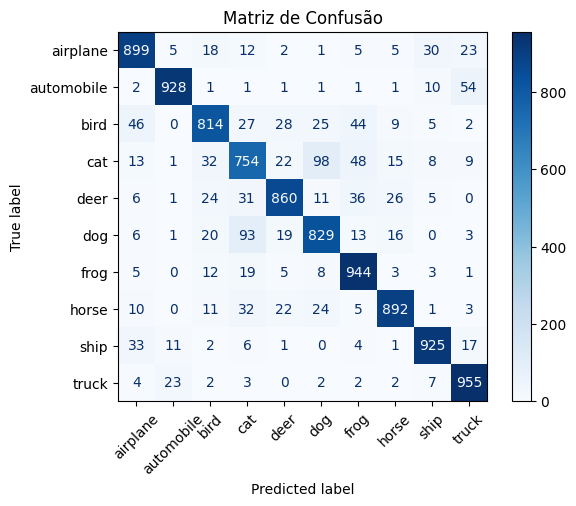

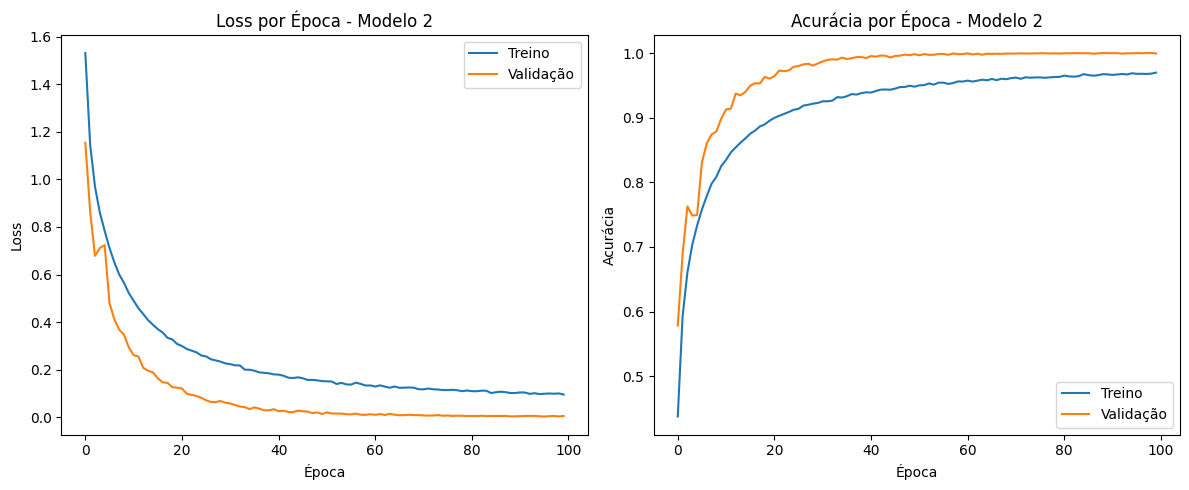

In [42]:
evaluate_full_metrics(model2, test_loader, device, class_names=classes, show_confusion=True)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses2, label='Treino')
plt.plot(val_losses2, label='Validação')
plt.title('Loss por Época - Modelo 2')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs2, label='Treino')
plt.plot(val_accs2, label='Validação')
plt.title('Acurácia por Época - Modelo 2')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.tight_layout()
plt.show()


# Desempenho do Segundo Modelo

O desempenho do modelo DeeperCNN no conjunto de teste foi significativamente superior ao modelo anterior. Com uma acurácia geral de 88,00%, acurácia balanceada de 88,00%, precisão macro de 88,03%, recall macro de 88,00% e F1-score macro de 87,96%, o modelo demonstrou excelente capacidade de generalização e robustez.

A matriz de confusão mostra um número expressivo de acertos em praticamente todas as classes, com destaque para "truck" (955), "automobile" (928), "ship" (925) e "frog" (944), todas com mais de 900 predições corretas. Isso revela que o modelo foi altamente eficaz em classes com formas bem definidas ou padrões visuais marcantes.

As classes de animais, tradicionalmente mais difíceis, também apresentaram melhorias significativas. A classe "cat", por exemplo, foi corretamente identificada 754 vezes (comparado a 612 do modelo anterior), apesar de ainda ser confundida em alguns casos com "dog" (98 erros) e "deer" (44 erros). Essa redução na confusão entre classes semelhantes indica que o modelo conseguiu capturar melhor as sutilezas visuais das imagens.

Os gráficos de loss e acurácia do modelo DeeperCNN demonstram um comportamento de aprendizado muito mais robusto e consistente ao longo das 100 épocas de treinamento.

No gráfico de perda (loss), observamos uma queda acentuada nas primeiras épocas para ambos os conjuntos (treino e validação), com estabilização progressiva e contínua nas etapas finais. O fato de o loss de validação manter-se abaixo do loss de treino durante quase todo o processo indica uma excelente capacidade de generalização, com baixo risco de sobreajuste.

O gráfico de acurácia reforça essa observação: o modelo atinge rapidamente mais de 90% de acurácia em validação nas primeiras 20 épocas, ultrapassando 99% nas épocas finais. A acurácia de treino acompanha esse crescimento de forma suave, sinalizando um treinamento estável e eficiente.